In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import h5py
import copy

import amici
from petab.C import *
import petab
import petab.C
import pypesto
import pypesto.petab
from pypesto.optimize import minimize
from pypesto.startpoint import uniform
from pypesto.engine import MultiProcessEngine, MultiThreadEngine
from pypesto.optimize.optimizer import FidesOptimizer
import pypesto.optimize as optimize

from pypesto.visualize import waterfall
from pypesto.visualize import parameters
from pypesto.visualize.model_fit import visualize_optimized_model_fit
from pypesto.visualize import profiles

import pypesto.profile as profile
from pypesto.optimize import ScipyOptimizer
from pypesto.profile.options import ProfileOptions

from pypesto.visualize.model_fit import visualize_optimized_model_fit, _get_simulation_rdatas

In [3]:
def hex_to_rgba_gradient(color1, color2, n):
    '''
    Create a gradient in rgba between two hex colors
    '''
    # Convert to rgba
    c1 = matplotlib.colors.to_rgba(matplotlib.colors.hex2color(color1))
    c2 = matplotlib.colors.to_rgba(matplotlib.colors.hex2color(color2))

    return [[(c1[i]*(n-j-1) + c2[i]*j)/(n-1) for i in range(4)] for j in range(n)]

# find the index for cut off based on Chi square distribution CI 95%
def find_cut_off_index(result, ci = 0.95):
    '''
    Find the cut off index for the data based on the Chi square distribution
    '''

    # calculate the chi square distribution
    cut_off_value = scipy.stats.chi2.ppf(ci, 1)

    # find the index
    best_fval = result.optimize_result.list[0].fval

    for i in range(len(result.optimize_result.list)):
        if result.optimize_result.list[i].fval > best_fval + cut_off_value:
            break
    
    return i - 1

def find_cut_off_x_trace(result, ci = 0.95, flatten = True):

    cut_off_value = scipy.stats.chi2.ppf(ci, 1)
    best_fval = result.optimize_result.list[0].fval

    # store the optimized x trace that are below the cut off value
    x_trace_within_cut_off = []
    if flatten:
        for i in range(find_cut_off_index(result, ci)):
            
            fval_trace = result.optimize_result.list[i].history.get_fval_trace()
            x_trace = result.optimize_result.list[i].history.get_x_trace()

            for j in range(len(fval_trace)):
                if fval_trace[j] < best_fval + cut_off_value:
                    x_trace_within_cut_off.append(x_trace[j])
    else:
        for i in range(find_cut_off_index(result, ci)):
            
            fval_trace = result.optimize_result.list[i].history.get_fval_trace()
            x_trace = result.optimize_result.list[i].history.get_x_trace()

            x_trace_within_cut_off_i = []
            for j in range(len(fval_trace)):
                if fval_trace[j] < best_fval + cut_off_value:
                    x_trace_within_cut_off_i.append(x_trace[j])
            x_trace_within_cut_off.append(x_trace_within_cut_off_i)

    return x_trace_within_cut_off

In [4]:
# Plot setting
plt.rcParams['font.size'] = 30

dpi = 100
wid = int(2560/dpi)
hei = int(1600/dpi)

In [5]:
# number of optimization runs
n_runs = 5000

In [6]:
# Define the folder where you want to save the figures
folder_path = "/Users/yuhongliu/Documents/OV/figures/8_Lp/n"+str(n_runs)+"/"

# If the folder does not exist, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# optimization
hierarchical = True

petab_yaml = 'petab_files/Lp_model.yaml'
petab.validate(petab_yaml)
petab_problem = petab.Problem.from_yaml(petab_yaml)

np.random.seed(500)

problem = pypesto.petab.PetabImporter(
        petab_problem,
        hierarchical=hierarchical,
        model_name=f"LP_Model",
    ).create_problem(force_compile=True)

problem.objective.amici_model.setAllStatesNonNegative()

# some model properties
print("Model parameters:", list(problem.objective.amici_model.getParameterIds()), "\n")
print("Model const parameters:", list(problem.objective.amici_model.getFixedParameterIds()), "\n")
print("Model outputs:   ", list(problem.objective.amici_model.getObservableIds()), "\n")
print("Model states:    ", list(problem.objective.amici_model.getStateIds()), "\n")

Compiling amici model to folder /Users/yuhongliu/Documents/OV/models/8_Lp/amici_models/0.26.1/LP_Model.
2024-10-22 23:09:48.672 - amici.petab.sbml_import - INFO - Importing model ...
2024-10-22 23:09:48.672 - amici.petab.sbml_import - INFO - Validating PEtab problem ...
2024-10-22 23:09:48.682 - amici.petab.sbml_import - INFO - Model name is 'LP_Model'.
Writing model code to '/Users/yuhongliu/Documents/OV/models/8_Lp/amici_models/0.26.1/LP_Model'.
2024-10-22 23:09:48.682 - amici.petab.sbml_import - INFO - Species: 0
2024-10-22 23:09:48.682 - amici.petab.sbml_import - INFO - Global parameters: 12
2024-10-22 23:09:48.683 - amici.petab.sbml_import - INFO - Reactions: 0
2024-10-22 23:09:48.693 - amici.petab.sbml_import - INFO - Observables: 1
2024-10-22 23:09:48.693 - amici.petab.sbml_import - INFO - Sigmas: 1
2024-10-22 23:09:48.694 - amici.petab.sbml_import - DEBUG - Adding output parameters to model: ['observableParameter1_tumor_vol', 'noiseParameter1_tumor_vol']
2024-10-22 23:09:48.695

running build_ext
running AmiciBuildCMakeExtension
------------------------------ model_ext ------------------------------

==> Configuring:
$ cmake -S /Users/yuhongliu/Documents/OV/models/8_Lp/amici_models/0.26.1/LP_Model -B /Users/yuhongliu/Documents/OV/models/8_Lp/amici_models/0.26.1/LP_Model/build_model_ext -G Ninja -DCMAKE_MAKE_PROGRAM=/opt/homebrew/bin/ninja -DCMAKE_BUILD_TYPE=Release -DCMAKE_INSTALL_PREFIX:PATH=/Users/yuhongliu/Documents/OV/models/8_Lp/amici_models/0.26.1/LP_Model/LP_Model -DCMAKE_VERBOSE_MAKEFILE=ON -DCMAKE_MODULE_PATH=/opt/homebrew/lib/python3.12/site-packages/amici/lib/cmake/SuiteSparse;/opt/homebrew/lib/python3.12/site-packages/amici/lib64/cmake/SuiteSparse -DKLU_ROOT=/opt/homebrew/lib/python3.12/site-packages/amici -DAMICI_PYTHON_BUILD_EXT_ONLY=ON -DPython3_EXECUTABLE=/opt/homebrew/opt/python@3.12/bin/python3.12

==> Building:
$ cmake --build /Users/yuhongliu/Documents/OV/models/8_Lp/amici_models/0.26.1/LP_Model/build_model_ext --config Release

==> Install

2024-10-22 23:10:06.032 - amici.petab.sbml_import - INFO - Finished Importing PEtab model            (1.74E+01s)


Model parameters: ['rho', 'kappa', 'psi', 'alpha', 'phi', 'beta', 'delta', 'observableParameter1_tumor_vol', 'noiseParameter1_tumor_vol'] 

Model const parameters: ['virus_injection'] 

Model outputs:    ['tumor_vol'] 

Model states:     ['C_u', 'C_i', 'V', 'L_p'] 



In [7]:
loading = True

if loading:
    # load result history from file
    result = pypesto.store.read_result('optimization_history/n'+ str(n_runs) +'.hdf5')

else:
    # optimize the model
    result = minimize(
        problem=problem,
        optimizer=FidesOptimizer(verbose=False, options={'maxiter': 5000}),
        n_starts=n_runs,
        engine=MultiProcessEngine(),
        # startpoint_method=uniform,
        history_options = pypesto.HistoryOptions(trace_record=True, storage_file='optimization_history/n'+ str(n_runs) +'.hdf5'),
        filename='optimization_history/n'+ str(n_runs) +'.hdf5',
    )

# print result summary
print(result.summary())

Loading the profiling result failed. It is highly likely that no profiling result exists within optimization_history/n5000.hdf5.
Loading the sampling result failed. It is highly likely that no sampling result exists within optimization_history/n5000.hdf5.


## Optimization Result 

* number of starts: 5000 
* best value: 1547.8730074218452, id=3864
* worst value: inf, id=998
* number of non-finite values: 4232

* execution time summary:
	* Mean execution time: 0.176s
	* Maximum execution time: 5.509s,	id=10
	* Minimum execution time: 0.008s,	id=4421
* summary of optimizer messages:

  |   Count | Message                                                     |
  |--------:|:------------------------------------------------------------|
  |    4232 | Encountered non-finite function inf value at initial point. |
  |     588 | Converged according to fval difference                      |
  |     180 | Trust Region Radius too small to proceed                    |

* best value found (approximately) 190 time(s)
* number of plateaus found: 28

A summary of the best run:

### Optimizer Result

* optimizer used: <FidesOptimizer  hessian_update=default verbose=False options={'maxiter': 5000}>
* message: Converged according to fval difference 
* number

In [8]:
parameters_from_result = dict(zip(problem.x_names, result.optimize_result.list[0]['x']))

In [9]:
# Scale all parameters and put them into a dictionary
scaled_parameters = {key: 10**value for key, value in parameters_from_result.items()}

# Print the scaled parameters
print("Scaled parameters:")
for key, value in scaled_parameters.items():
    print(f"{key}: {value}")

Scaled parameters:
rho: 0.08776595780824988
kappa: 0.00010000000000256855
psi: 0.00010000000000000021
phi: 0.018790942222729298
beta: 0.014938038536479563
alpha: 0.03316443558837005
delta: 9999.999999999898


In [11]:
# Extract parameters from the dictionary
rho = scaled_parameters['rho']
kappa = scaled_parameters['kappa']
psi = scaled_parameters['psi']
phi = scaled_parameters['phi']
beta = scaled_parameters['beta']
alpha = scaled_parameters['alpha']
delta = scaled_parameters['delta']

# Print the parameters to verify
print(f"rho: {rho}")
print(f"kappa: {kappa}")
print(f"psi: {psi}")
print(f"phi: {phi}")
print(f"beta: {beta}")
print(f"alpha: {alpha}")
print(f"delta: {delta}")

rho: 0.08776595780824988
kappa: 0.00010000000000256855
psi: 0.00010000000000000021
phi: 0.018790942222729298
beta: 0.014938038536479563
alpha: 0.03316443558837005
delta: 9999.999999999898


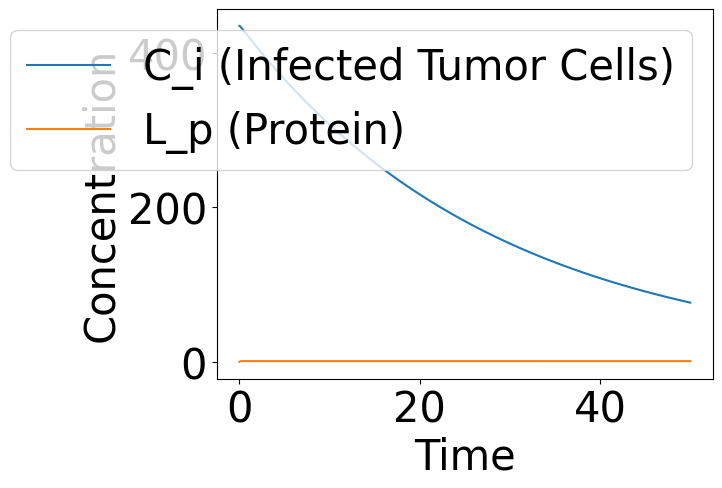

In [20]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the system of ODEs
def system(y, t, rho, kappa, psi, alpha, phi):
    Ci, Lp = y
    dCi_dt = - Lp * alpha * Ci
    dLp_dt = phi * Ci - alpha * Lp**100
    return [dCi_dt, dLp_dt]

# Initial conditions and parameters
y0 = [1 / (kappa + np.exp(-rho) * (1/400 - kappa)), 0]
t = np.linspace(0, 50, 500)  # Time vector
params = (rho, kappa, psi, alpha, phi)

# Solve the system of ODEs
sol = odeint(system, y0, t, args=params)

# Plot the results
Ci_sol = sol[:, 0]
Lp_sol = sol[:, 1]
plt.plot(t, Ci_sol, label='C_i (Infected Tumor Cells)')
plt.plot(t, Lp_sol, label='L_p (Protein)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()